# Library Install

model library install
```bash
pip install git+https://github.com/abcd-EGH/srnn-ae.git
```

In [13]:
!pip uninstall srnn-ae -q -y

In [14]:
!pip install git+https://github.com/abcd-EGH/srnn-ae.git -q

In [15]:
!pip show srnn-ae

Name: srnn-ae
Version: 0.3.2
Summary: Sparsely connections RNN + AutoEncoder Model for Anomaly Detection in Time Series
Home-page: https://github.com/abcd-EGH/srnn-ae
Author: Jihwan Lee (abcd-EGH)
Author-email: wlghks7790@gmail.com
License: MIT
Location: C:\Users\Jihwan\anaconda3\envs\ml_env\Lib\site-packages
Requires: arch, matplotlib, numpy, pandas, scikit-learn, seaborn, torch
Required-by: 


In [ ]:
!pip install arch

In [14]:
from srnn_ae import ECSLAE, TimeSeriesDataset, set_random_seed, hyperparameter_setting, read_dataset, data_plot_with_anomalies, train,\
compute_reconstruction_errors, evaluate_and_visualize
import os
import json
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from torch.utils.data import TensorDataset, Dataset, DataLoader, Subset
from sklearn.metrics import (
    precision_score, recall_score, f1_score, 
    roc_auc_score, average_precision_score, 
    cohen_kappa_score, roc_curve, precision_recall_curve,
    confusion_matrix
)
import matplotlib.pyplot as plt
import time
import datetime
import seaborn as sns
from arch import arch_model

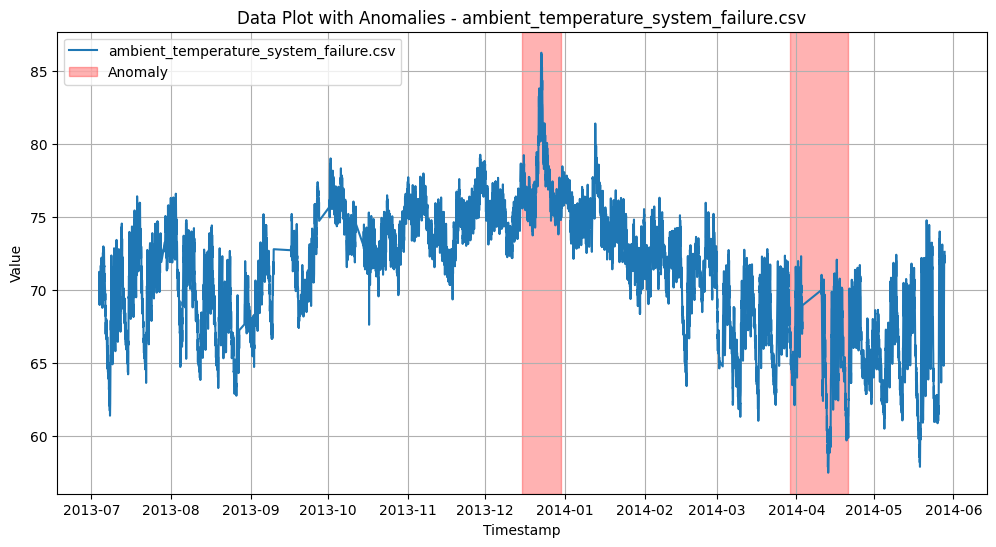

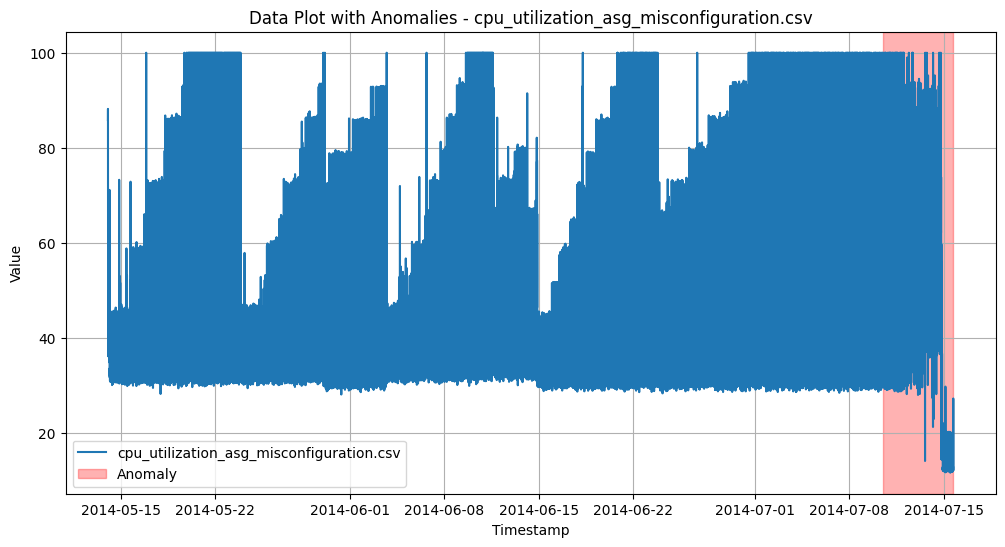

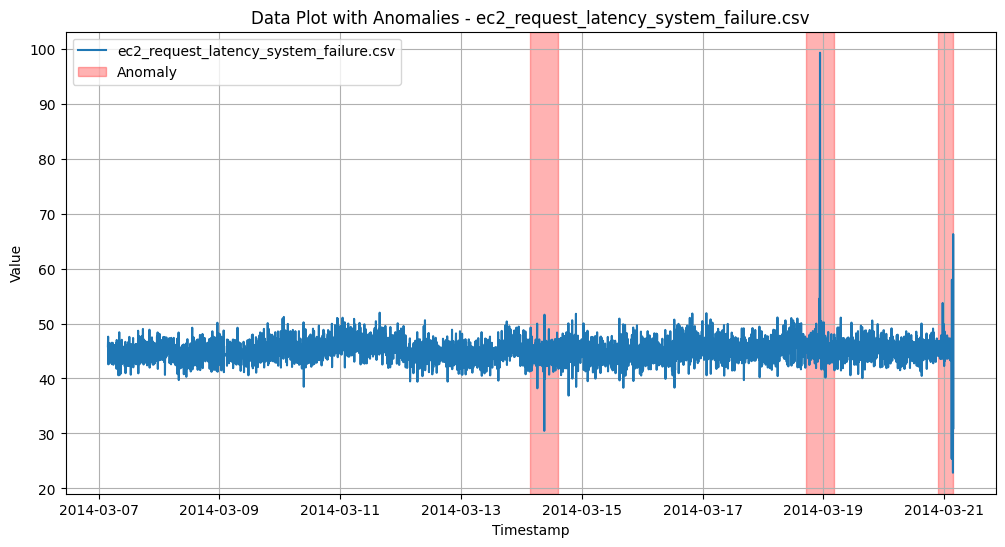

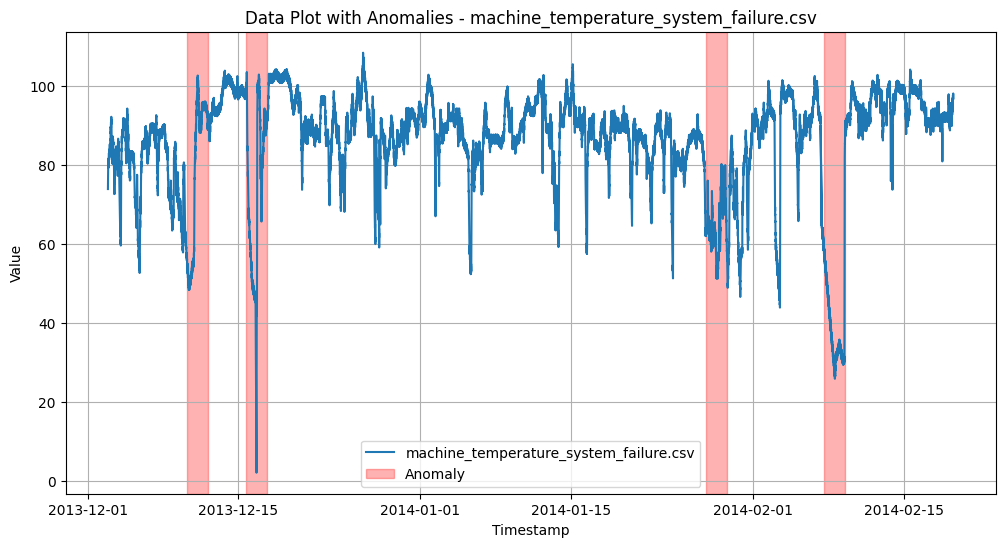

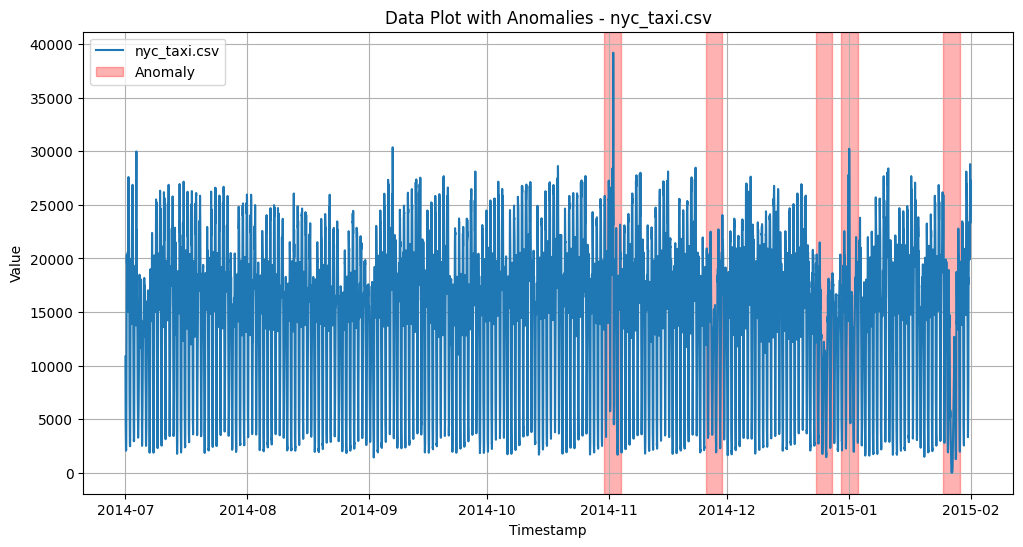

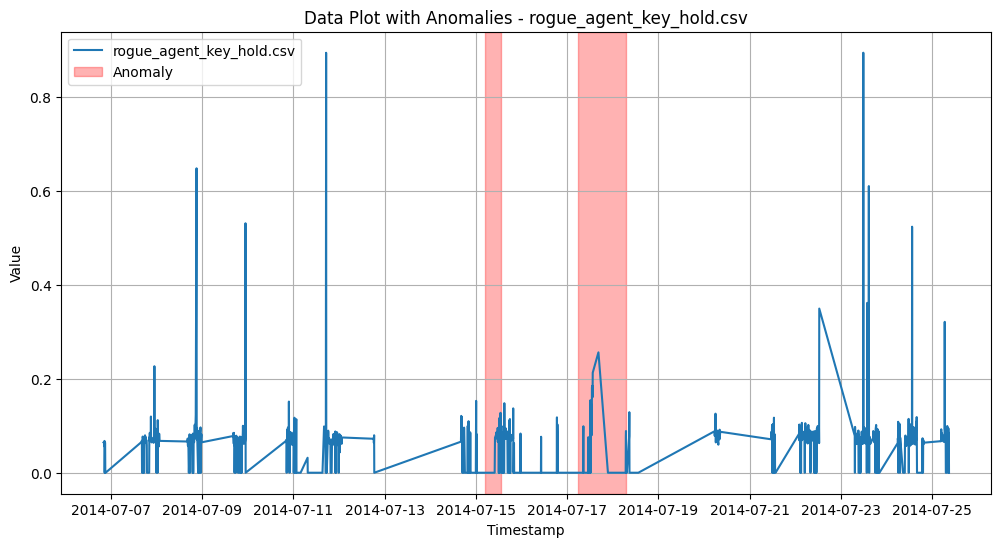

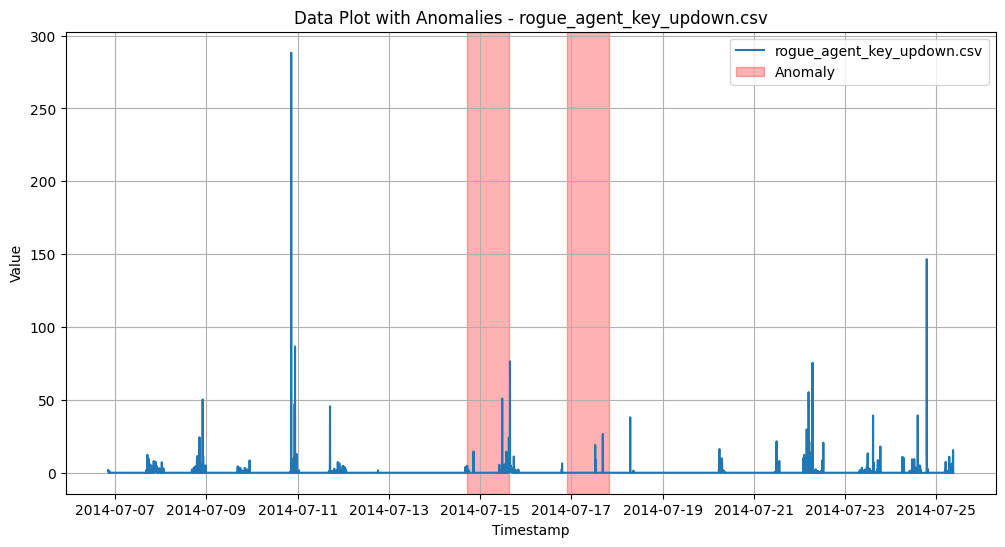

In [15]:
data_plot_with_anomalies(train_data_dir = './NAB/data/realKnownCause') # 이상치 라벨을 포함한 plot 생성 (폴더 단위)

In [16]:
set_random_seed()

# 하이퍼파라미터 및 가설 넘버 설정
args = hyperparameter_setting(N=10, hidden_size=8, num_layers=1, batch_size=396, num_epochs=20, window_size=288, l1_lambda=1e-5, limit_skip_steps=10)
h='H3' # 꼭 확인하기!
print("Hyperparameter & Hypothesis Number Setting Complete.")

# 디바이스 설정 (GPU가 사용 가능하면 GPU, 아니면 CPU)

model = ECSLAE(
    N=args['N'], 
    input_size=args['input_size'],
    hidden_size=args['hidden_size'],
    output_size=args['output_size'],
    num_layers=args['num_layers'],
    limit_skip_steps=args['limit_skip_steps'],
    seed=args['random_seed'],
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print("Model Initialization Complete.")

# Prepare data and create Dataset
file_name = './NAB/data/realKnownCause/machine_temperature_system_failure.csv'
abnormal_data, abnormal_label = read_dataset(file_name)
abnormal_data, abnormal_label = abnormal_data[:-1], abnormal_label[:-1]  # Remove last data point to fit window and batch size

window_size = args['window_size']
batch_size = args['batch_size']
stride = 12

# Create the full dataset
full_dataset = TimeSeriesDataset(abnormal_data, abnormal_label, window_size, stride=stride)

# Function to identify window indices where all labels are normal (1)
def get_normal_window_indices(dataset):
    normal_indices = []
    for idx in range(len(dataset)):
        _, _, window_labels = dataset[idx]
        if torch.all(window_labels == 1):
            normal_indices.append(idx)
    return normal_indices

# Get indices for training (only normal windows)
train_indices = get_normal_window_indices(full_dataset)

# Create Subsets for training and testing
train_dataset = Subset(full_dataset, train_indices)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
print("Data Load Complete.")

# 손실 함수 및 옵티마이저 설정 - 논문에선 Adadelta를 사용했으나, 20 epoch 동안 loss가 떨어지지 않아 Adam으로 대체
criterion = nn.MSELoss() # MSELoss, L1Loss, SmoothL1Loss
optimizer = optim.AdamW(model.parameters(), lr=args['learning_rate'], weight_decay=1e-5)
print("Loss function & Optimizer Complete.")

print("[Args]")
print(args)
print()

print("[Model]")
print(model)
print()

print("[Data]")
print(f"Number of samples in train dataset: {len(train_dataset)}")
print(f"Number of batches in train dataloader: {len(train_dataloader)}")
print()

print("[Criterion & Optimizer]")
print(criterion)
print(optimizer)
print()

Hyperparameter & Hypothesis Number Setting Complete.
Model Initialization Complete.
Processing file: realKnownCause/machine_temperature_system_failure.csv
Data Load Complete.
Loss function & Optimizer Complete.
[Args]
{'N': 10, 'input_size': 1, 'hidden_size': 8, 'output_size': 1, 'num_layers': 1, 'limit_skip_steps': 10, 'learning_rate': 0.001, 'l1_lambda': 1e-05, 'batch_size': 396, 'window_size': 288, 'num_epochs': 20, 'random_seed': 777}

[Model]
ECSLAE(
  (autoencoders): ModuleList(
    (0-9): 10 x AutoEncoder(
      (encoder): Encoder(
        (cells): ModuleList(
          (0): sLSTMCell(
            (lstm): LSTMCell(1, 8)
          )
        )
      )
      (decoder): Decoder(
        (cells): ModuleList(
          (0): sLSTMCell(
            (lstm): LSTMCell(9, 8)
          )
        )
        (output_layer): Linear(in_features=8, out_features=1, bias=True)
      )
    )
  )
)

[Data]
Number of samples in train dataset: 1584
Number of batches in train dataloader: 4

[Criterion & 

현재 가설명: H3

Epoch [1/20], Loss: 0.681492, (Duration: 26.06s, Current Time: 17:55:58, Estimated End Time: 18:04:13)
Epoch [2/20], Loss: 0.626308, (Duration: 24.25s, Current Time: 17:56:22, Estimated End Time: 18:03:38)
Epoch [3/20], Loss: 0.563896, (Duration: 24.63s, Current Time: 17:56:47, Estimated End Time: 18:03:45)
Epoch [4/20], Loss: 0.514153, (Duration: 26.12s, Current Time: 17:57:13, Estimated End Time: 18:04:11)
Epoch [5/20], Loss: 0.459918, (Duration: 25.51s, Current Time: 17:57:38, Estimated End Time: 18:04:01)
Epoch [6/20], Loss: 0.410139, (Duration: 25.37s, Current Time: 17:58:04, Estimated End Time: 18:03:59)
Epoch [7/20], Loss: 0.360782, (Duration: 25.37s, Current Time: 17:58:29, Estimated End Time: 18:03:59)
Epoch [8/20], Loss: 0.318590, (Duration: 24.60s, Current Time: 17:58:54, Estimated End Time: 18:03:49)
Epoch [9/20], Loss: 0.276607, (Duration: 25.51s, Current Time: 17:59:19, Estimated End Time: 18:04:00)
Epoch [10/20], Loss: 0.239724, (Duration: 27.06s, Current Tim

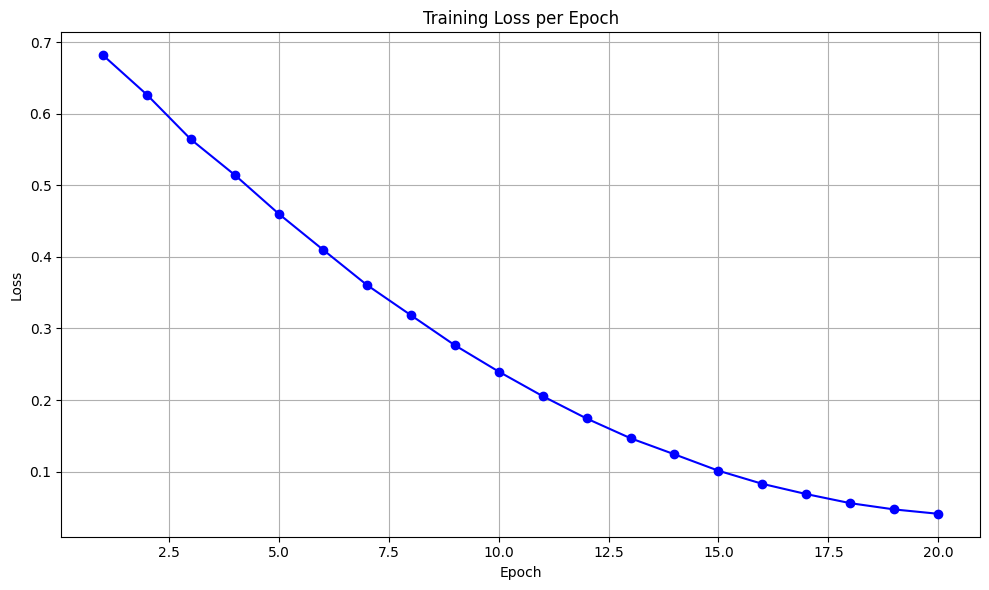

In [17]:
# 학습 실행
print('현재 가설명:', h)
print()

train(
    model=model,
    dataloader=train_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    l1_lambda=args['l1_lambda'],
    num_epochs=args['num_epochs'],
    h=h
)

In [18]:
# 모델 가중치 저장
os.makedirs(h, exist_ok=True)
torch.save(model.state_dict(), f'{h}/ensemble_autoencoder_weights.pth')
print(f"모델 가중치가 {h}/ensemble_autoencoder_weights.pth'에 저장되었습니다.")

모델 가중치가 H3/ensemble_autoencoder_weights.pth'에 저장되었습니다.


In [19]:
model.load_state_dict(torch.load(f'{h}/ensemble_autoencoder_weights.pth', weights_only=True))
print("모델 가중치가 로드되었습니다.")

모델 가중치가 로드되었습니다.


In [20]:
# 테스트 실행 (Static Threshold, threshold_percentile=95)
test_file_name = './NAB/data/realKnownCause/machine_temperature_system_failure.csv'
test_abnormal_data, test_abnormal_label = read_dataset(test_file_name)
test_abnormal_data, test_abnormal_label = test_abnormal_data[:-1], test_abnormal_label[:-1]

# 모든 데이터를 테스트에 사용
test_dataset = TimeSeriesDataset(test_abnormal_data, test_abnormal_label, window_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

total_length = len(test_abnormal_data)

all_errors, reconstructed_data, binary_labels = compute_reconstruction_errors(model, test_dataloader, device, total_length, test_abnormal_label)

Processing file: realKnownCause/machine_temperature_system_failure.csv
Testing Complete.


Using static Reconstruction Error Threshold (95th percentile): 0.055560
[Classification Metrics]
Precision: 0.7903
Recall: 0.3955
F1-Score: 0.5272
ROC AUC: 0.7687
PR AUC: 0.5202
Cohen Kappa: 0.4934

Reconstruction error plot saved to H3/StaticThreshold\reconstruction_error_static_threshold.png


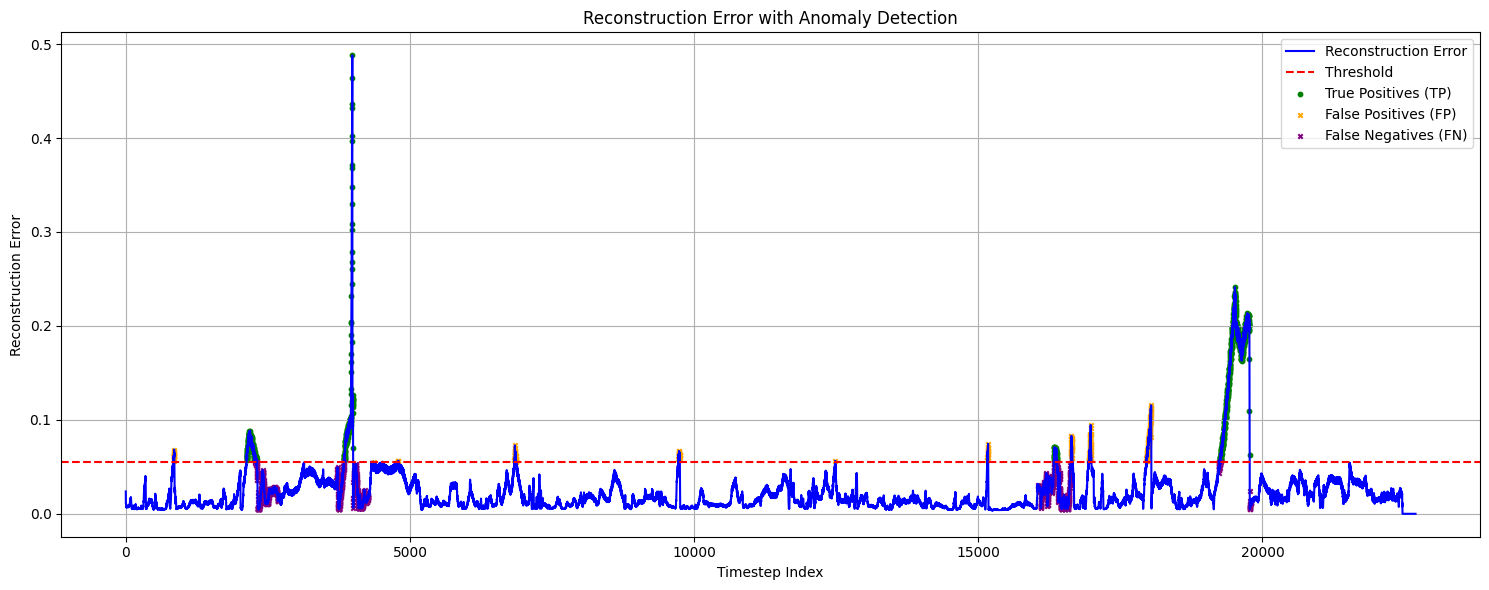

Actual vs Reconstructed Data plot saved to H3/StaticThreshold\actual_vs_reconstructed_data.png


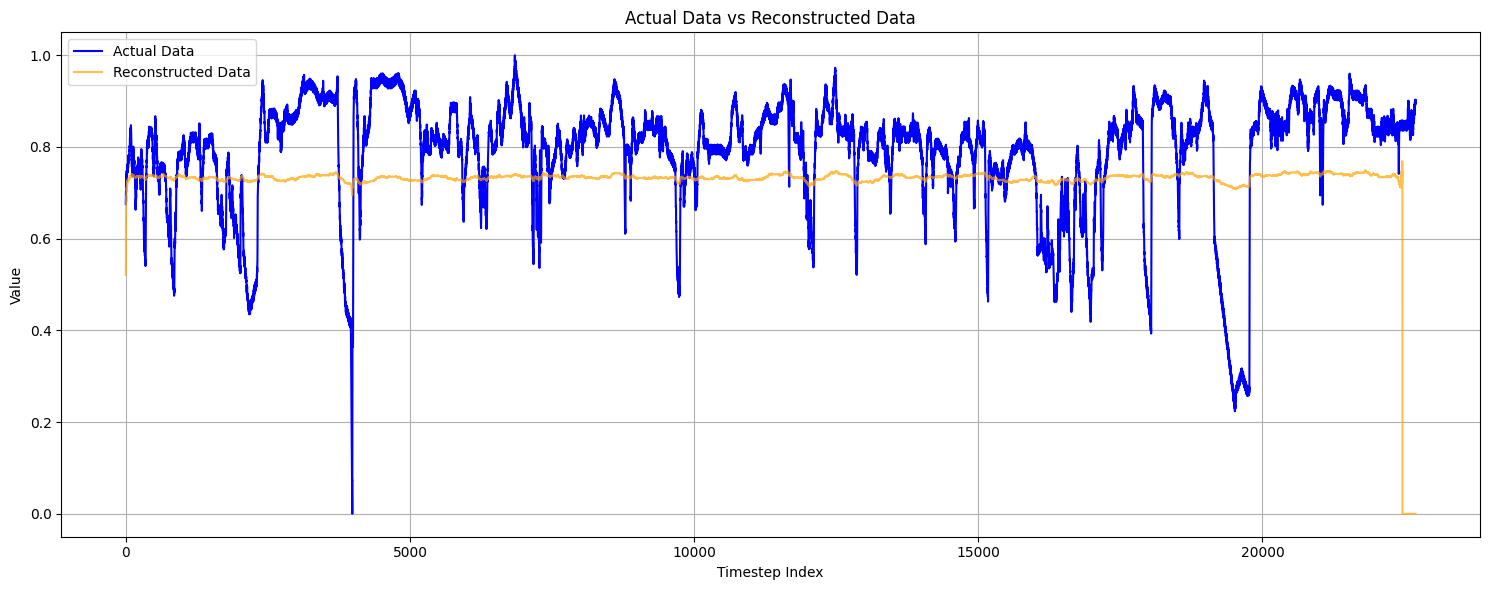

ROC curve plot saved to H3/StaticThreshold\roc_curve_all_data.png


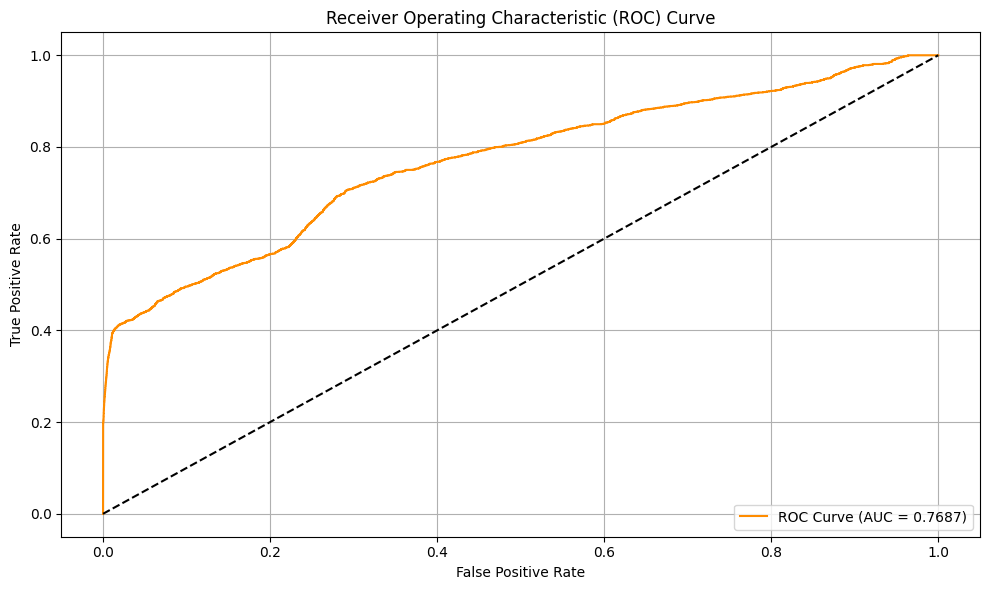

PR curve plot saved to H3/StaticThreshold\pr_curve_all_data.png


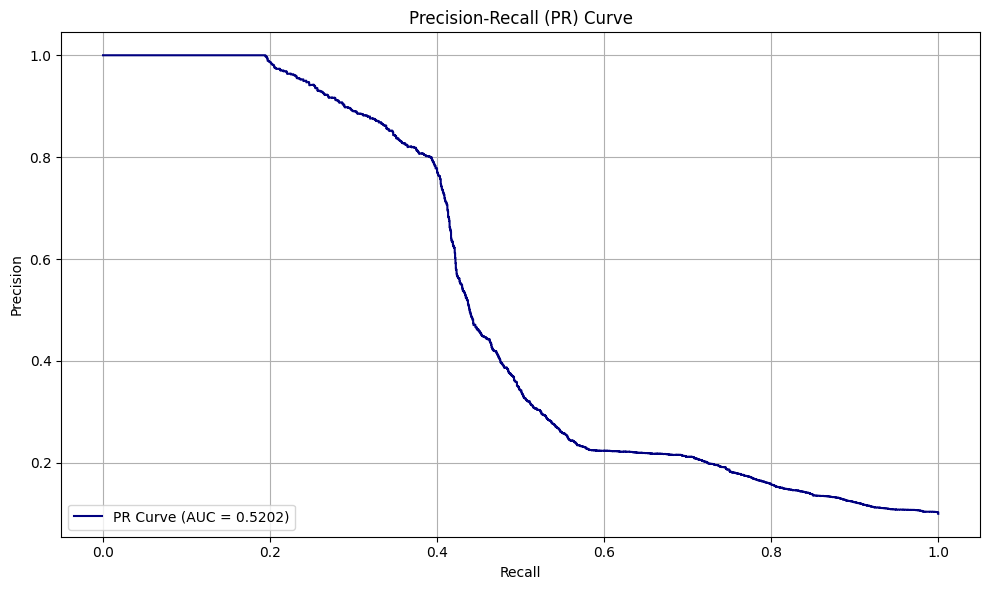

Confusion matrix plot saved to H3/StaticThreshold\confusion_matrix.png


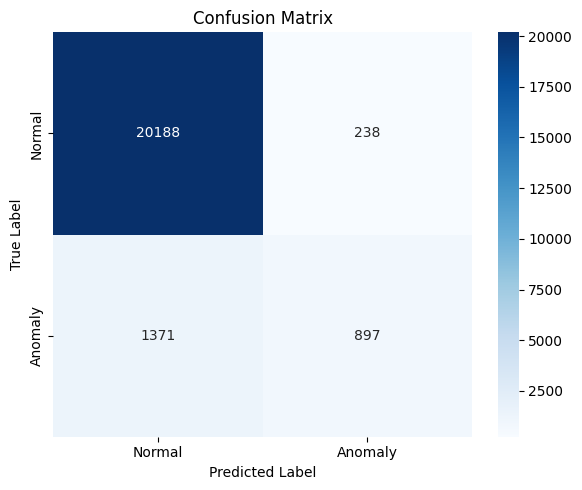

Reconstruction error with anomalies plot saved to H3/StaticThreshold\reconstruction_error_with_anomalies_static.png


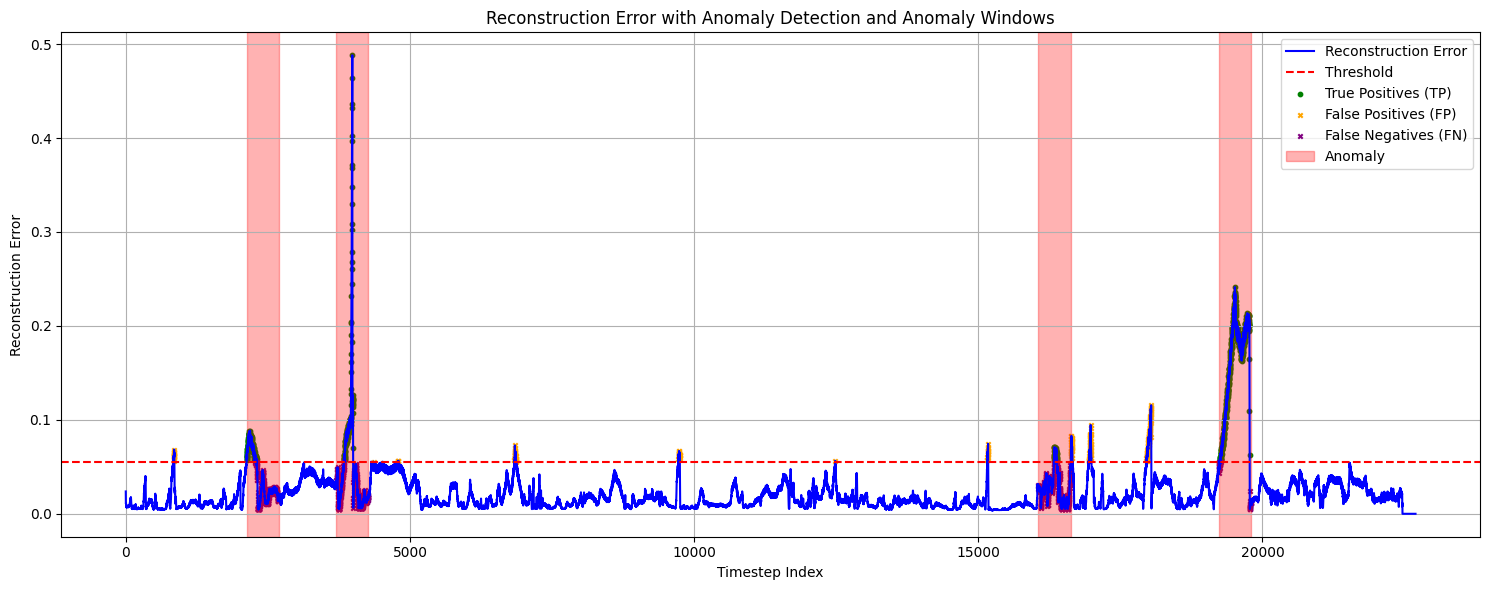

In [21]:
# 테스트 실행 (Static Threshold)
evaluate_and_visualize(
    all_errors=all_errors,
    reconstructed_data=reconstructed_data,
    binary_labels=binary_labels,
    actual_data=test_abnormal_data,
    h=h+'/StaticThreshold',
    threshold_method='static',
    threshold_percentile=95,
)

Using dynamic Reconstruction Error Threshold based on 20-window moving average and 1.15*std
[Classification Metrics]
Precision: 0.1251
Recall: 0.2989
F1-Score: 0.1764
ROC AUC: 0.7687
PR AUC: 0.5202
Cohen Kappa: 0.0412

Reconstruction error plot saved to H3/DynamicThresholdwithMA\reconstruction_error_moving_avg_threshold.png


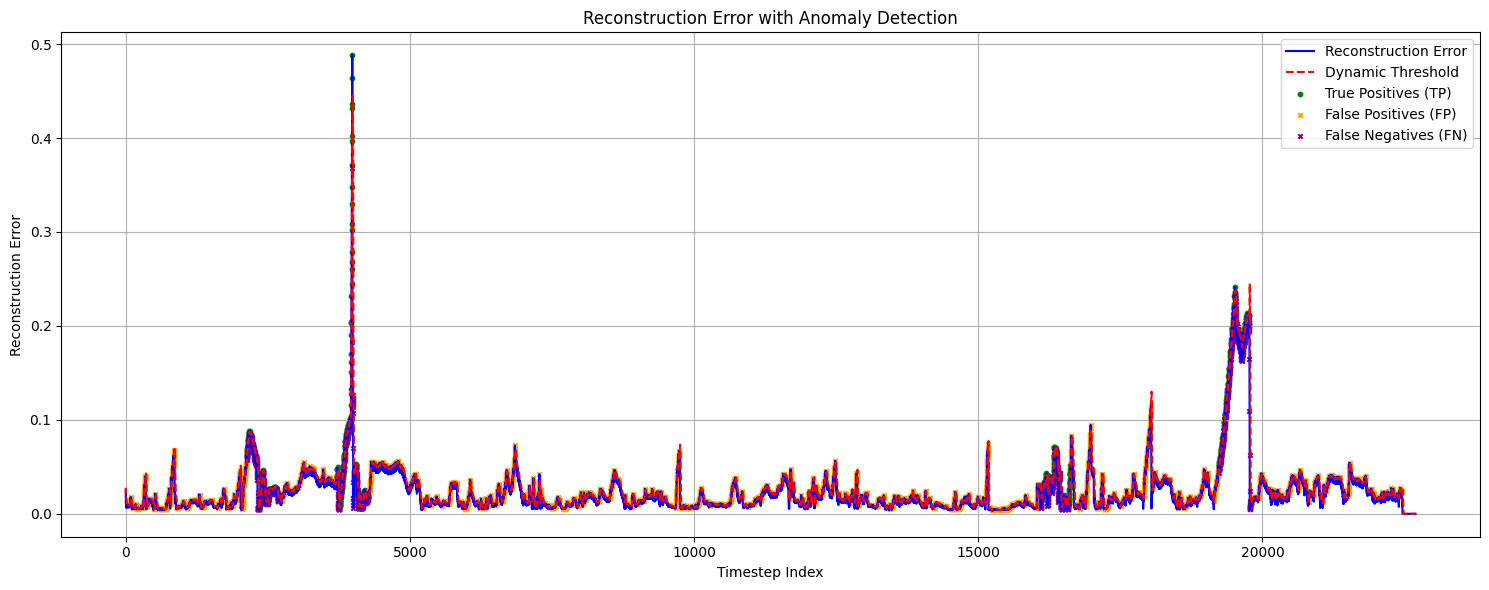

Actual vs Reconstructed Data plot saved to H3/DynamicThresholdwithMA\actual_vs_reconstructed_data.png


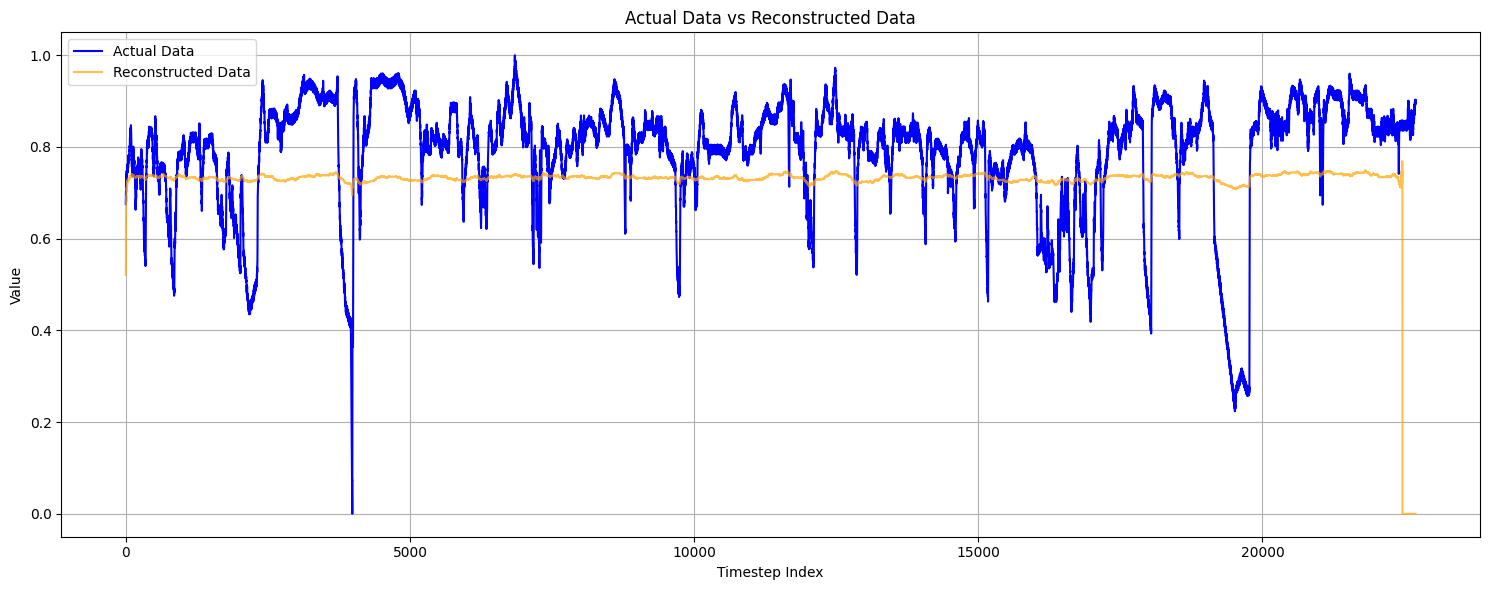

ROC curve plot saved to H3/DynamicThresholdwithMA\roc_curve_all_data.png


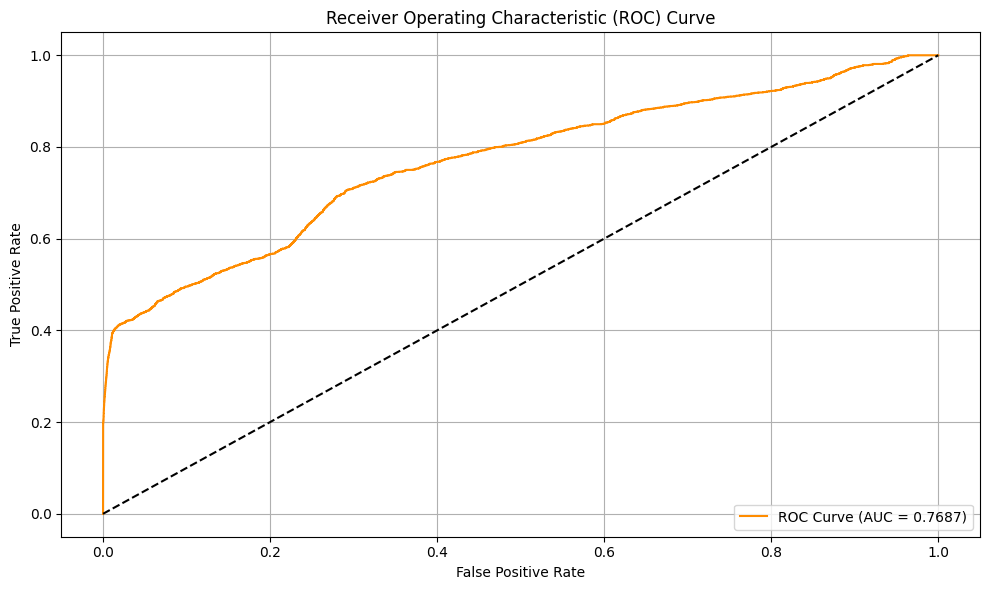

PR curve plot saved to H3/DynamicThresholdwithMA\pr_curve_all_data.png


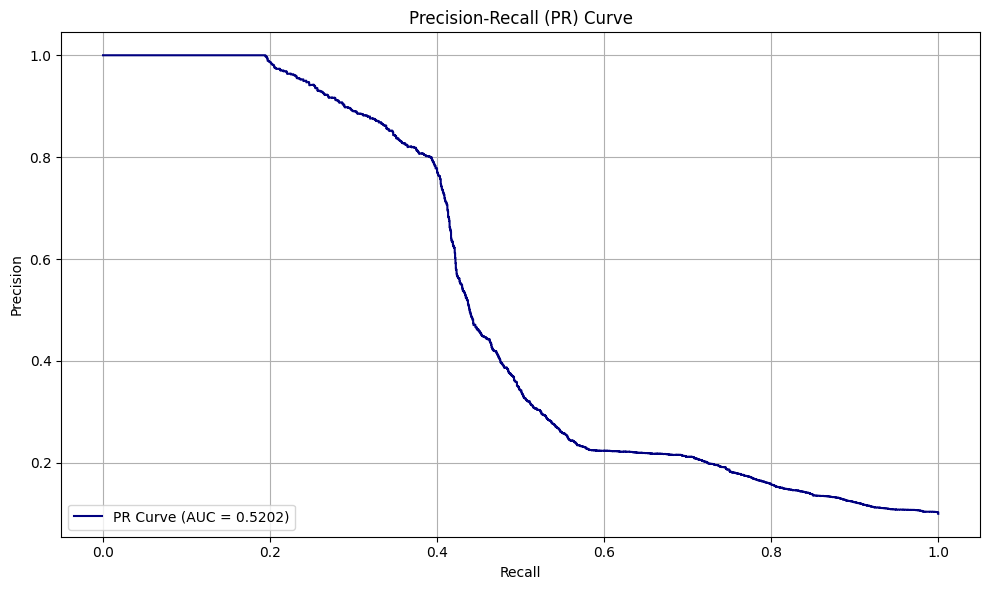

Confusion matrix plot saved to H3/DynamicThresholdwithMA\confusion_matrix.png


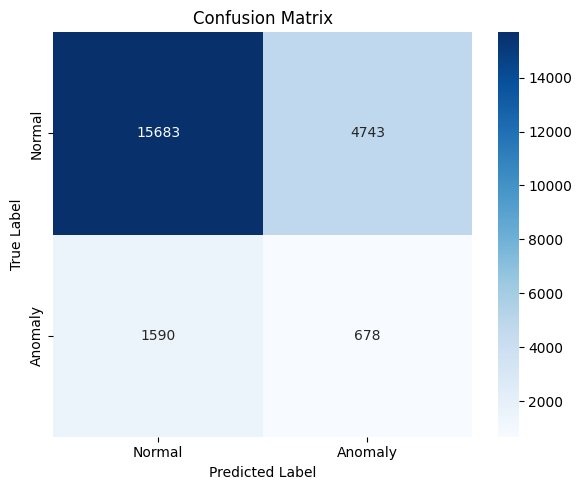

Reconstruction error with anomalies plot saved to H3/DynamicThresholdwithMA\reconstruction_error_with_anomalies_moving_avg.png


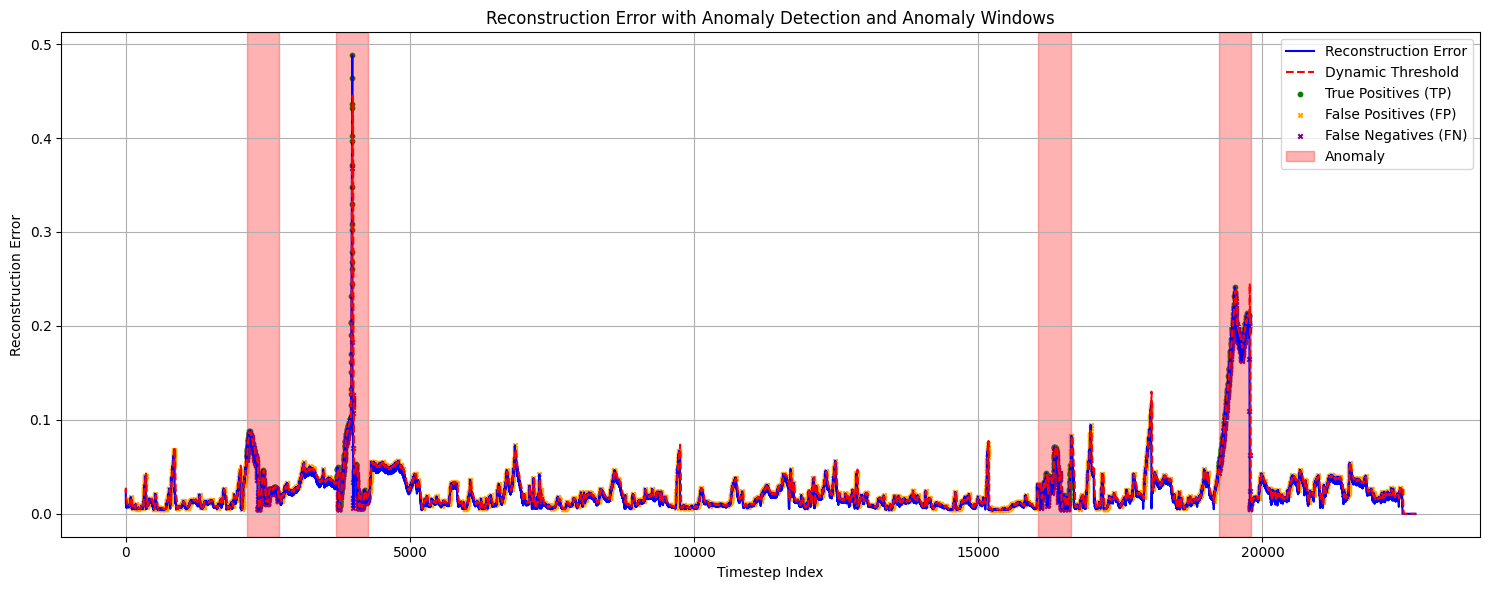

In [22]:
# 테스트 실행 (Dynamic Threshold, Moving Average)
evaluate_and_visualize(
    all_errors=all_errors,
    reconstructed_data=reconstructed_data,
    binary_labels=binary_labels,
    actual_data=test_abnormal_data,
    h=h+'/DynamicThresholdwithMA',
    threshold_method='moving_avg',
    k=1.15
)

Fitting GARCH(1,1) model on scaled reconstruction errors...
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                138959.
Distribution:                  Normal   AIC:                          -277912.
Method:            Maximum Likelihood   BIC:                          -277888.
                                        No. Observations:                22694
Date:                Tue, Nov 26 2024   Df Residuals:                    22694
Time:                        18:23:30   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
---------------------------------------------------------------------------

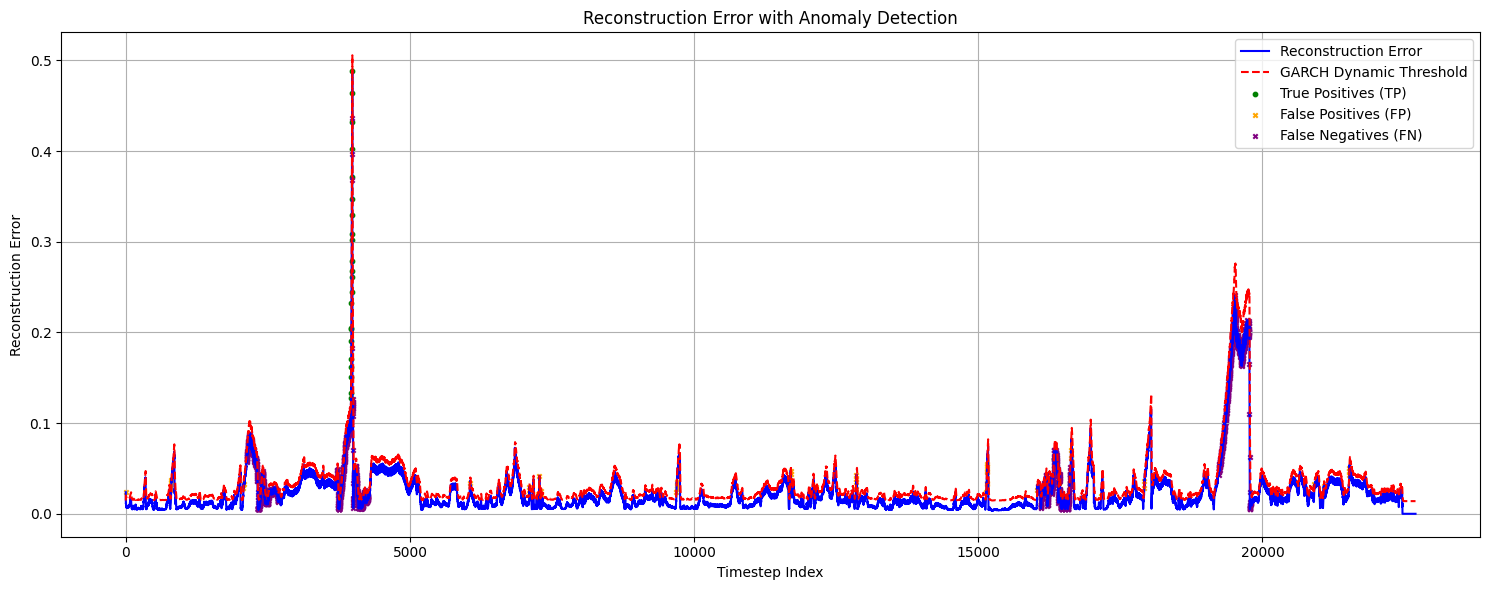

Actual vs Reconstructed Data plot saved to H3/DynamicThresholdwithGARCH\actual_vs_reconstructed_data.png


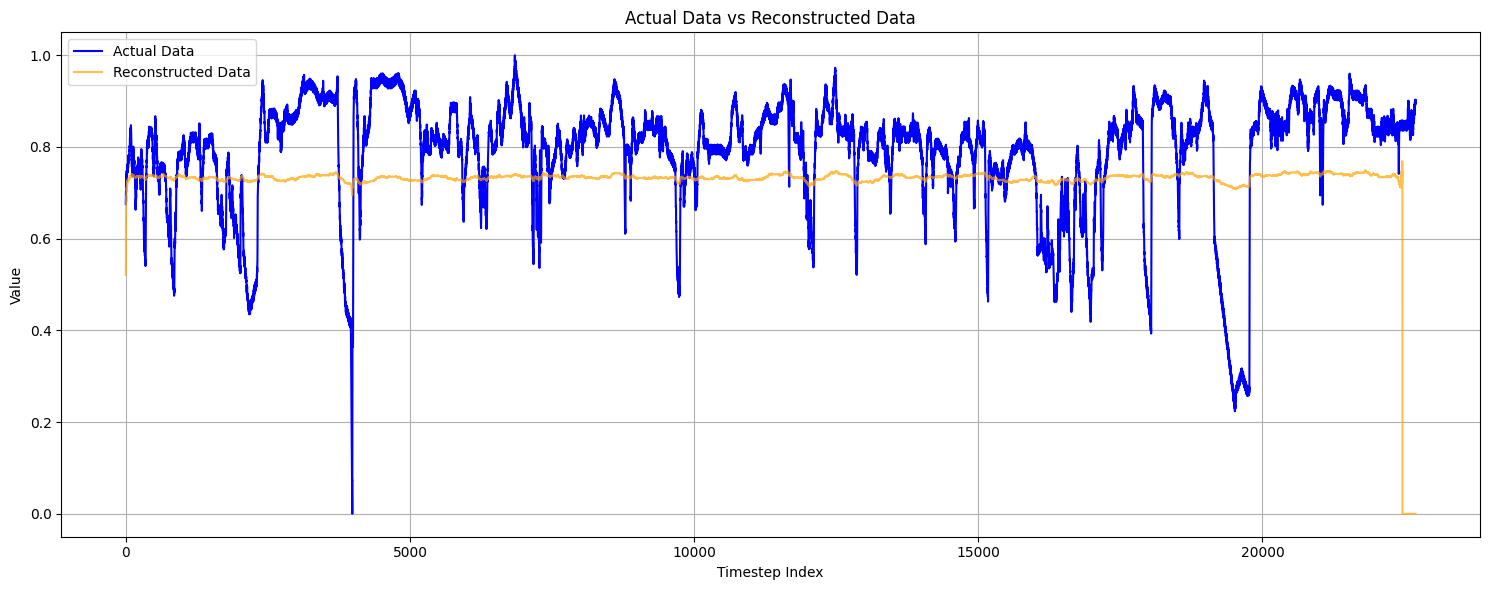

ROC curve plot saved to H3/DynamicThresholdwithGARCH\roc_curve_all_data.png


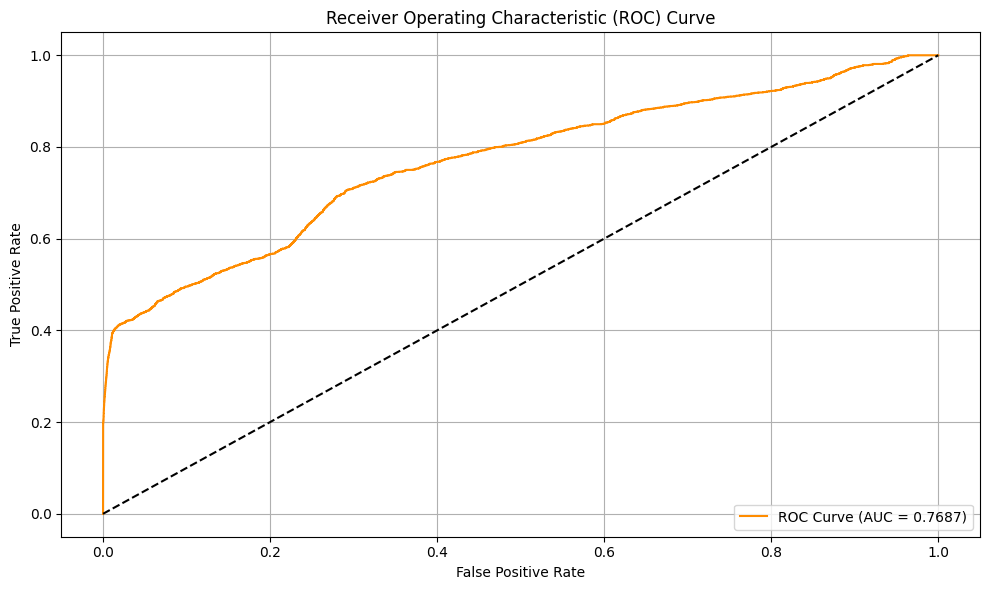

PR curve plot saved to H3/DynamicThresholdwithGARCH\pr_curve_all_data.png


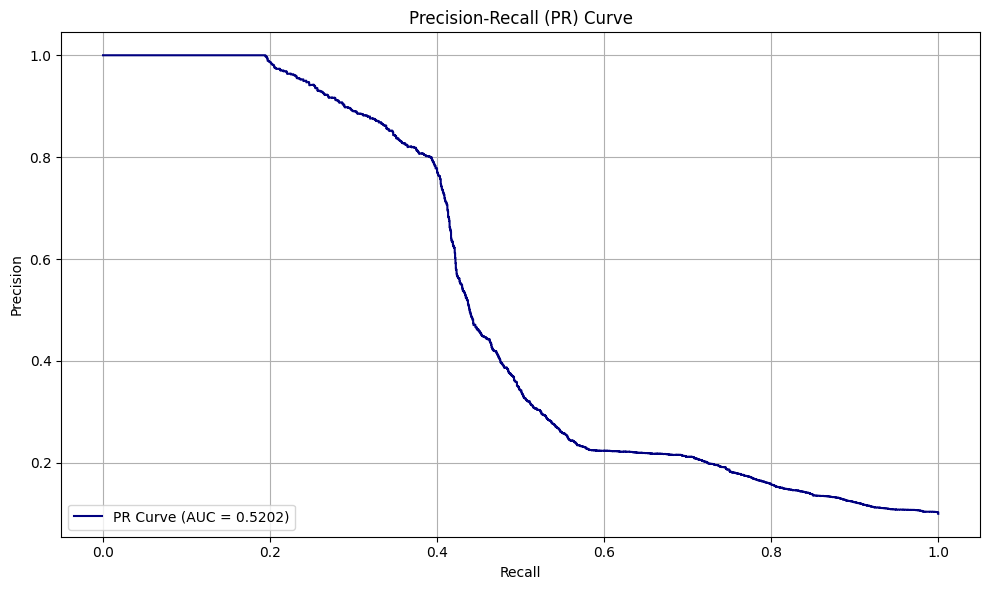

Confusion matrix plot saved to H3/DynamicThresholdwithGARCH\confusion_matrix.png


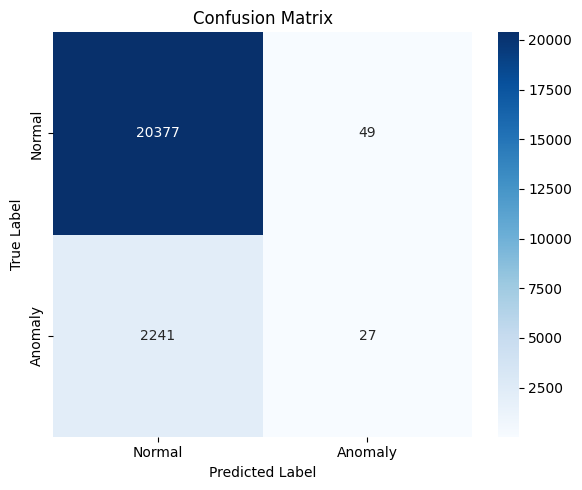

Reconstruction error with anomalies plot saved to H3/DynamicThresholdwithGARCH\reconstruction_error_with_anomalies_garch.png


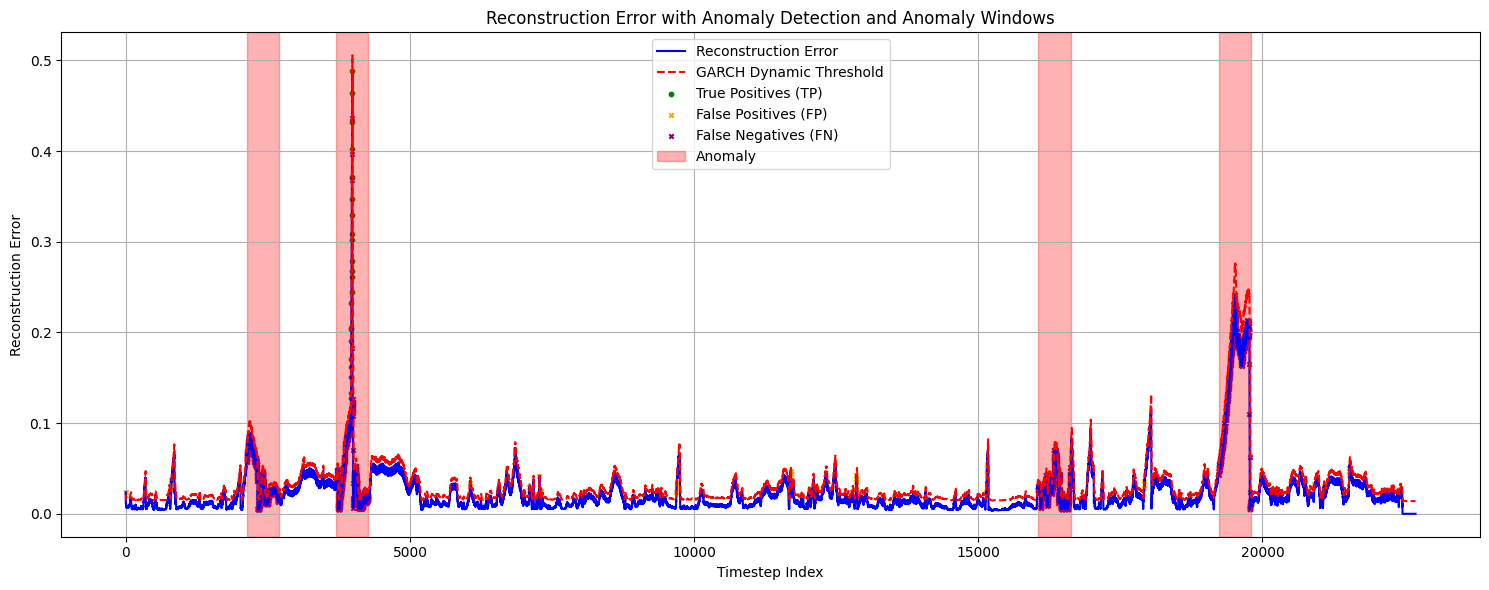

In [25]:
# 테스트 실행 (Dynamic Threshold, GARCH)
evaluate_and_visualize(
    all_errors=all_errors,
    reconstructed_data=reconstructed_data,
    binary_labels=binary_labels,
    actual_data=test_abnormal_data,
    h=h+'/DynamicThresholdwithGARCH',
    threshold_method='garch',
    k=1.25,
)